# Baseline data

## Import librairies & data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from fonctions import Fonctions
from IPython.display import Image
plt.style.use("fivethirtyeight")
%matplotlib inline
f=Fonctions()

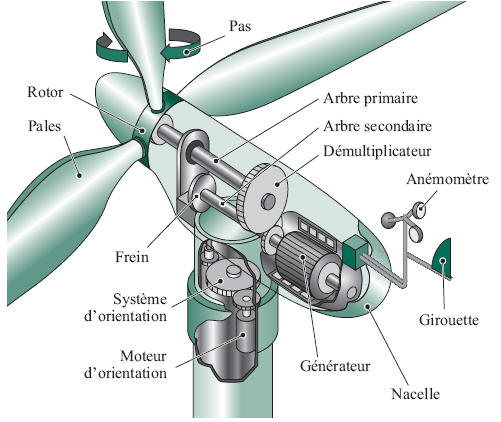

In [2]:
Image('eolien.jpg')

In [3]:
data = f.read_original_data('haute_borne_data_2017_2020.csv')

In [4]:
f.analys_form_dataframe(data)

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------- The dataframe's shape: (217588, 138) ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------  Head dataframe  ------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,45.0,45.0,45.0,0.0,14.0,14.0,14.0,0.0,...,nan,nan,358.0,nan,nan,nan,358.0,nan,nan,nan
1,R80721,2017-01-26T02:40:00+01:00,-1.0,-1.0,-1.0,0.0,10.0,10.0,10.0,0.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,R80721,2017-01-26T13:50:00+01:00,-1.0,-1.0,-1.0,0.0,10.0,10.0,10.0,0.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,R80721,2017-01-26T15:00:00+01:00,-1.0,-1.0,-1.0,0.0,10.0,10.0,10.0,0.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,R80721,2017-02-18T01:10:00+01:00,45.0,45.0,45.0,0.0,17.0,17.0,17.0,0.0,...,nan,nan,8.0,nan,nan,nan,8.0,nan,nan,nan


In [5]:
# f.show_map_missing_values(data)

## Description des variables

In [6]:
# description = f.read_original_data('data_description.csv')

## Nettoyage rapide des valeurs nulles

In [7]:
df = data.copy()

=> suppression des colonnes nulles et des lignes dont les valeurs sont manquantes

In [8]:
df = f.delet_features_having_more_then_50_per_cent_miss_values(df)

In [9]:
# f.show_map_missing_values(df)

## Features selection & split

In [10]:
# On prend toutes les variables sauf les colonnes avec des valeurs nulles et les 2 variables catégorielles
# Notre dataset n'est plus constitué que de m = 130 000

X_train, X_test, y_train, y_test = f.features_selection_and_split_with_columns_to_drop(df, ['P_avg', 'Wind_turbine_name', 'Date_time'], 'P_avg')

In [11]:
# f.show_split_shape(X_train, X_test, y_train, y_test)

## Régression linéaire avec toutes les variables

### Score avec Statmodel

In [12]:
# Fit et score sur le X_train

f.statmod_function(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  P_avg   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.292e+07
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:59:05   Log-Likelihood:            -1.9583e+05
No. Observations:              106802   AIC:                         3.919e+05
Df Residuals:                  106686   BIC:                         3.930e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.0179      0.496    -70.622      0.0

**Interprétation**

- **R2** de 1 avec 170 features signifie clairement que nous avons un problème. Les hypothèses d'un tel score sont : multicolinéarité (formule du calcul de l'énergie de la turbine / message d'erreur l'indiquant) ou overfitting.
- Nous constatons une certaine variabilité des **coefficients** et des **p-values** intéressantes mais dans la mesure où notre modèle ne semble pas respecter les hypothèses de la régression linéaire (avec une forte colinéarité), les résultats sont difficilement interprétables et fiables. 
- **Skew** négatif de -3.193 : indique une distribution décalée à droite de la médiane, et donc une queue de distribution étalée vers la gauche. Cela sous-entend que nos données sont fortement biaisées.

**Solutions**
- Vérifier l'overfitting avec la cross_val et le score sur le test
- Vérifier les présupposés de la régression linéaire 
- Réduire les features (matrice de corrélation / VIF ou PCA) afin de vérifier le présupposé de la multicolinéarité

### Cross validation & score avec Sklearn

Dans la mesure où nous n'avons pas supprimé les outliers, nous utilisons la MSE comme fonction_coût car la mise au carré des erreurs pondère plus fortement les valeurs abérrantes

---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score model sur les Train Sets avec Sklearn  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.9999888126923081
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Cross Validation : Accuracy - MSE : Train ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
                     0    1    2    3    4    5
CV Accuracy Train  1.0  1.0  1.0  1.0  1.0  1.0
CV MSE Train      -2.1 -2.4 -2.3 -2.4 -2.4 -2.2


-------------------------------------------------------------------------------

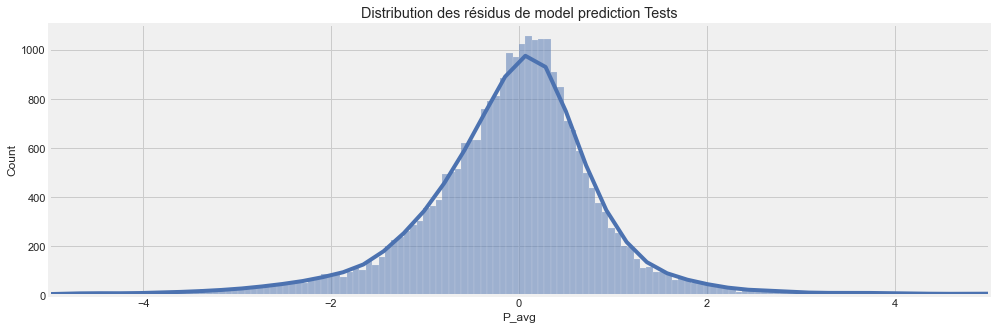

					  Moyenne des résidus : 0.007541381339799919
					  Médiane des résidus : 0.0015797030854969307
					  Mode des résidus : -0.21629144085377305


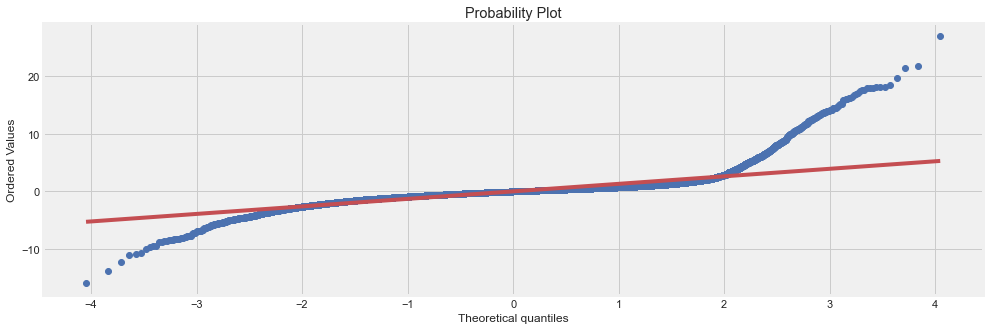

In [13]:
cv_train, cv_test, y_pred_train, y_pred_test = f.linear_regression_model(X_train, X_test, y_train, y_test, -5, 5, -5, 5)

Nous avons utilisé la cross validation pour éviter l'overfitting (et récuser notre hypothèse) et scorer le modèle sur plusieurs échantillons. Le score en cross_val et sur le test est quasiment identique. Nous n'avons pas d'overfitting.

### Analyse des présupposés du modèle

Notre distribution n'est pas gaussienne. Ce présupposé de la régression linéaire n'est pas respecté. 

Regardons du côté des pré-supposés de la régression linéaire (non colinéarité et distribution normale des résidus) dont le non-respect impliquerait que notre modèle n'est pas robuste. 

## Test avec la variable "Wind speed average" (Ws_avg)

Repartons d'un modèle plus simple en ne retenant qu'une seule feature pour voir comment se comporte notre modèle.

### Features selection & split

In [14]:
# Définition des features
X_2_train, X_2_test, y_2_train, y_2_test = f.features_selection_and_split_with_liste_of_Xfeatures(df, ['Ws_avg'], 'P_avg')

In [15]:
# f.show_split_shape(X_2_train, X_2_test, y_2_train, y_2_test)

### Score avec Statmodel

In [16]:
f.statmod_function(X_2_train, y_2_train)

                            OLS Regression Results                            
Dep. Variable:                  P_avg   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 4.818e+05
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:59:19   Log-Likelihood:            -7.1349e+05
No. Observations:              106802   AIC:                         1.427e+06
Df Residuals:                  106800   BIC:                         1.427e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -509.9923      1.392   -366.448      0.0

**Interpretation**

- On constate qu'avec la seule variable wind, la vitesse du vent explique 81% de la variance de l'énergie produite par l'éolienne. Le **R2** diminue mais peut-être notre modèle est plus robuste.
- **Coefficient** : pour chaque km/heure supplémentaire de vent, la puissance de l'éolienne augmentera de 157 Kw. On peut dire que ce coefficient est significatif car la **p-value** est à 0. A 5% près, la chance que notre coefficient soit le fruit du hasard est nulle.
- Le score du skew inférieur à 0,5 indique que nos données sont peu biaisées. 

### Cross validation & score avec Sklearn

---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score model sur les Train Sets avec Sklearn  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.8185593562861201
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Cross Validation : Accuracy - MSE : Train ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
                         0        1        2        3        4        5
CV Accuracy Train      0.8      0.8      0.8      0.8      0.8      0.8
CV MSE Train      -35964.1 -38179.5 -37288.3 -37774.7 -36475.8 -37323.6


-------

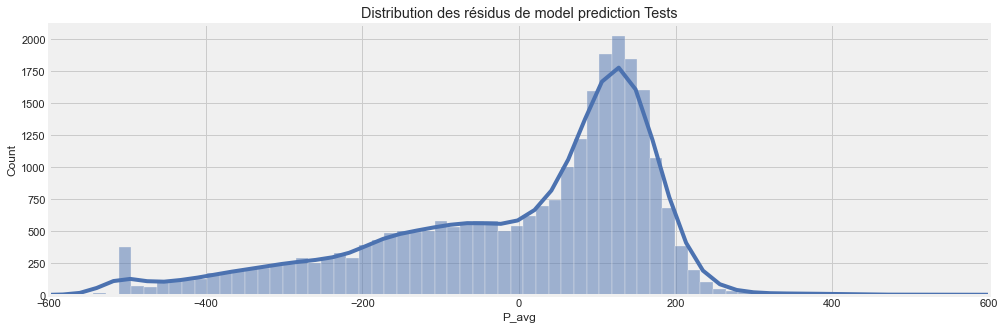

					  Moyenne des résidus : 0.908672752823307
					  Médiane des résidus : 64.72812136427393
					  Mode des résidus : -509.99229061120286


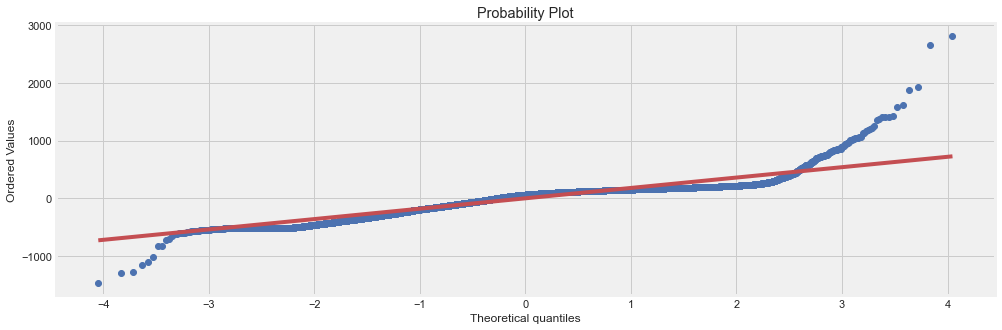

In [17]:
cv_train2, cv_test2, y_pred_train2, y_pred_test2 = f.linear_regression_model(X_2_train, X_2_test, y_2_train, y_2_test, -600, 600, -600, 600)

### Analyse des présupposés du modèle

Nous constatons que notre distribution ne suit toujours pas une loi normale malgré que le présupposé de la multinolinéarité ait été écarté. Notre modèle a des difficultés à estimer l'énergie générée par l'éolienne lorsque les valeurs sont élevées ou basses, avec une plus grande difficulté pour les valeurs élevées. Nous n'avons pas encore étudié ni géré les outliers. Il serait intéressant de voir quels sont-ils et à quel point ils influencent notre modèle.

Tentons dans un premier temps de gérer la multicolinéarité des features et d'entrainer/optimiser plusieurs modèles

# Selection features grâce à VIF

L'indicateur VIF (Variance Inflation Factor) va nous permettre de checker les variables colinéaires entre elles et ainsi prévenir la colinéarité entre les features pré-sélectionnées.

### Sélection sommaire avec le heatmap

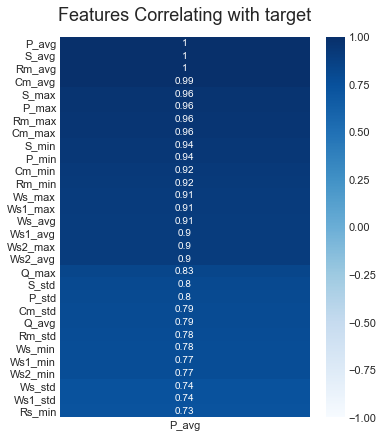

In [18]:
f.heatmap_corr_target_features('P_avg', df)

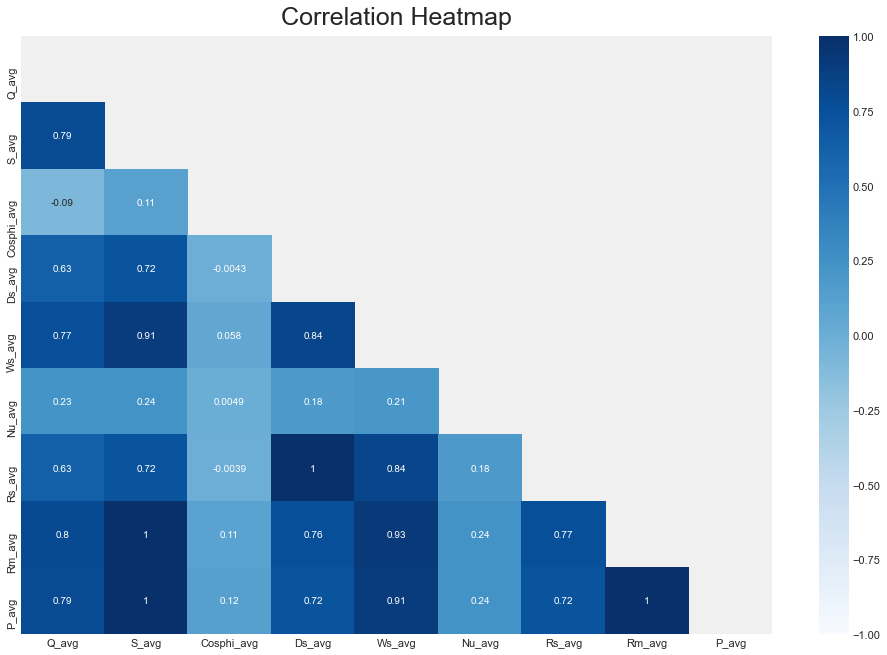

In [19]:
f.heatmap_corr(df, ['Q_avg','S_avg', 'Cosphi_avg','Ds_avg','Ws_avg', 'Nu_avg', 'Rs_avg','Rm_avg','P_avg'])

### Choix des variables en fonction de la colinéarité 

Avec le VIF, la colinéarité des features est écartée pour un résultat inférieur à 10. Nous avons fait de nombreux tests avec les variables les plus corrélées avec notre target. Les features qui obtiennent un résultat en deça de 10 sont 'Cosphi_avg', 'Rm_avg', 'Rs_avg'. Nous constatons que la variable Ws_avg augmente fortement la colinéarité.

In [20]:
f.vif_function(df, ['Ws_avg', 'Cosphi_avg', 'Rm_avg', 'Rs_avg']).T

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------  Variance Inflation Factor -----------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


,0,1,2,3
Features,Ws_avg,Cosphi_avg,Rm_avg,Rs_avg
vif_factor,56.0,13.0,12.0,17.0


In [21]:
f.vif_function(df, ['Cosphi_avg', 'Rm_avg', 'Rs_avg']).T

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------  Variance Inflation Factor -----------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


,0,1,2
Features,Cosphi_avg,Rm_avg,Rs_avg
vif_factor,6.0,4.0,11.0


**Description des features séletionnées**

*Cosinus phi* (ou appelé facteur de puissance/power factor) = C'est le rapport entre la puissance active et la puissance apparente. Il rend compte de l'efficacité d'un récepteur électrique pour consommer de la puissance lorsqu'il est traversé par un courant.C'est le cosinus de l'angle entre la tension et le courant, on le calcule en effectuant la division de la puissance réelle (Watt) par la puissance apparente (VA). Il est compris entre zéro et un (idéalement).

*Rm_avg* = torque - Elle protège la ligne de transmission des forces indésirables du vent en les redirigeant vers la tour. Il se mesure en nm. 

*Rs_avg* = rotor - Il est composé du nez de l'éolienne recevant les pales (en général trois), fixé sur un arbre tournant dans des paliers installés dans la nacelle. Le rotor, solidaire des pales, est entraîné par l'énergie du vent. 

### Visualisation des features sélectionnées

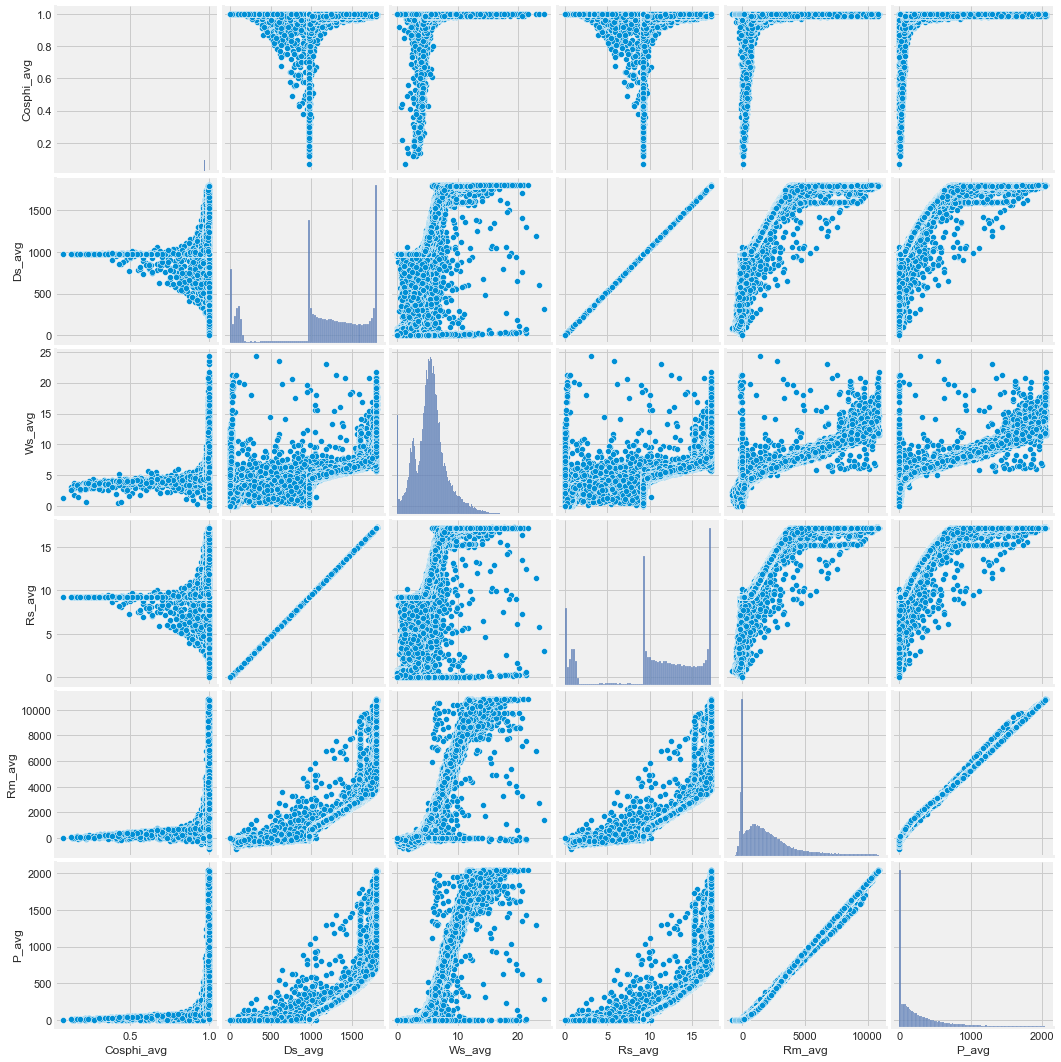

In [22]:
sns.pairplot(df[['Cosphi_avg','Ds_avg','Ws_avg', 'Rs_avg','Rm_avg','P_avg']])

# Deuxième itération

## Définition des variables et split

In [23]:
df2 = data.copy()

In [24]:
df2 = f.delet_features_having_more_then_50_per_cent_miss_values(df2)

In [25]:
X_train, X_test, y_train, y_test = f.features_selection_and_split_with_liste_of_Xfeatures(df2, ['Cosphi_avg', 'Rm_avg', 'Rs_avg'], 'P_avg')

## Preprocessing (pipeline)

Variables catégorielles : 
- pas de Nan 
- OneHotEncoder : peu de modalités

Variables numériques :
- gestion des Nan avec SimpleImputer / remplacement par la médiane
- Robsucaler car moins sensible aux valeurs extrêmes

In [26]:
f.pipeline_preprocessing(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Cosphi_avg', 'Rm_avg', 'Rs_avg']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index([], dtype='object'))])

## Entraînement et score des différents modèles

Méthode : Nous avons testé différentes combinaisons de modèles et variables d'après les analyses précédentes. 

Ridge regression : Il nous semble pertinent d'utiliser ce modèle pour essayer d'asséner des pénalités à une régression linéaire qui semblait trop parfaite. Nous imposons des contraintes quadratiques aux coefficients et tentons de réduire ainsi le surajustement du modèle.  

Lasso regression : bien que nous ayons déjà essayé de réduire la colinéarité des features au maximum, nous utilisons cet algo pour être certain que la colinéarité restante est minimisée. 

Régression linéaire : pour les modèles avec 1 feature explicative. 

### Ridge regression

---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score model sur les Train Sets avec Sklearn  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.996184290891352
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Cross Validation : Accuracy - MSE : Train ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
                       0      1      2      3      4      5
CV Accuracy Train    1.0    1.0    1.0    1.0    1.0    1.0
CV MSE Train      -784.7 -803.6 -783.6 -759.3 -786.7 -772.7


--------------------------------------------

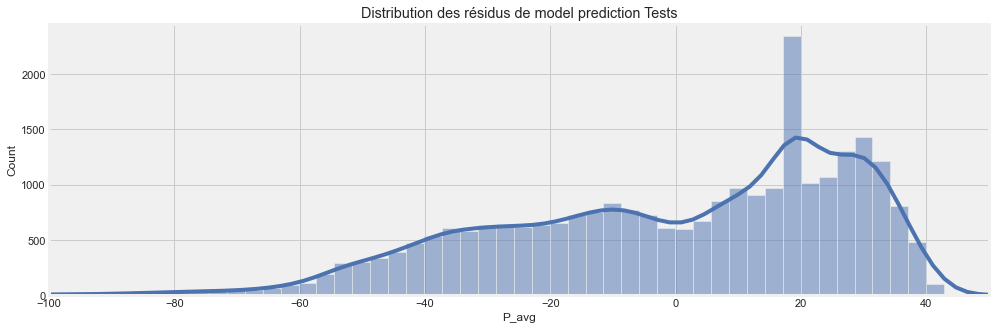

					  Moyenne des résidus : -0.11189511905595036
					  Médiane des résidus : 6.22687937041178
					  Mode des résidus : 19.165486997927843


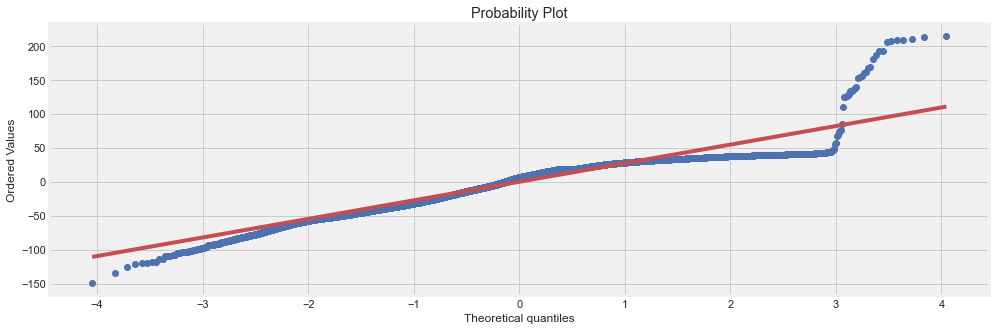

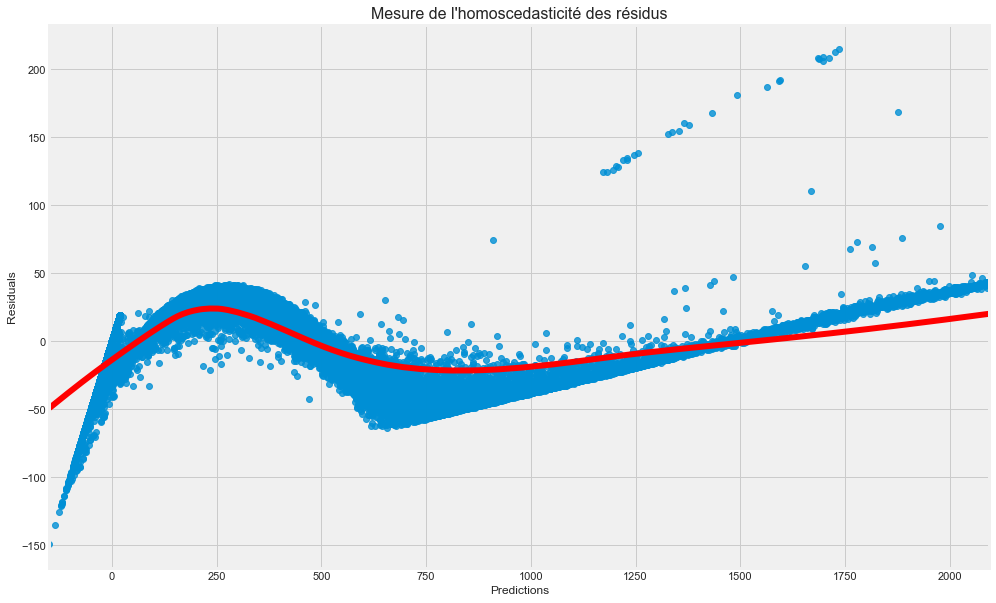

In [27]:
cv_train, cv_test, y_pred_train, y_pred_test = f.ridge_model(X_train, X_test, y_train, y_test, -100, 50, -100, 50)

**Analyse des résidus : le modèle est-il robuste ?**

- Le QQplot des résidus montre une légère amélioration du modèle par rapport à celui avec la feature "wind" mais n'est pas significative. Nous notons toujours cette difficulté à prédire les valeurs extrêmes.
- La variance des erreurs stochastiques est-elle la même pour chaque observation ? La variance des résidus est-elle constante ? Nous pouvons affirmer que l'hypothèse d'homoscédasticité des résidus est validée même si elle n'est pas parfaite. 

### Lasso

---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score model sur les Train Sets avec Sklearn  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.9961708651584309
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Cross Validation : Accuracy - MSE : Train ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
                       0      1      2      3      4      5
CV Accuracy Train    1.0    1.0    1.0    1.0    1.0    1.0
CV MSE Train      -787.2 -806.3 -786.4 -762.0 -789.9 -775.4


-------------------------------------------

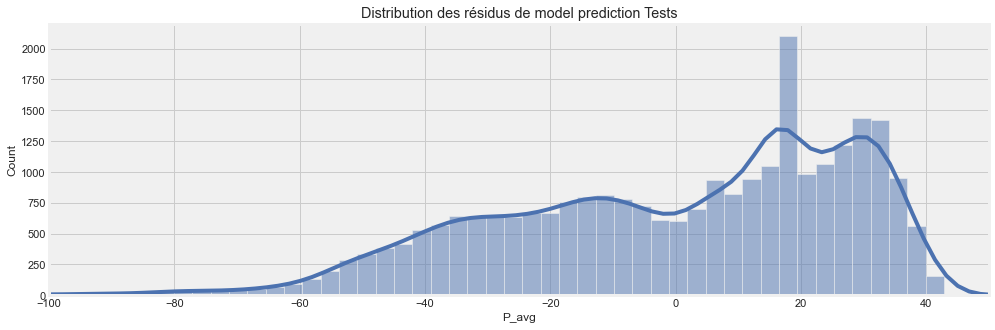

					  Moyenne des résidus : -0.11647796811784736
					  Médiane des résidus : 5.9914659845912865
					  Mode des résidus : 16.687283526793067


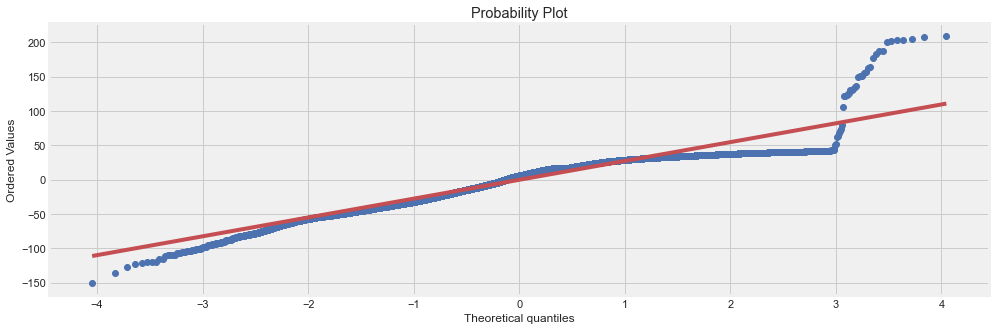

---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Optimisation du modèle avec GridSearchCV -------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 Best Score:  0.9961830737803709
						 Best Params:  {'lasso__alpha': 0.001}
---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score modèle GridSearchCV sur les Test Sets  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.9961620236320589


In [28]:
cv_train, cv_test, y_pred_train, y_pred_test = f.lasso_model(X_train, X_test, y_train, y_test, -100, 50, -100, 50)

### ElasticNet 

In [29]:
cv_train, cv_test, y_pred_train, y_pred_test = f.elasticNetCV_model(X_train, X_test, y_train, y_test)

---------------------------------------------------------------------------------------------------------------------------
------------------------------------  Score model sur les Train Sets avec Sklearn  ----------------------------------------
---------------------------------------------------------------------------------------------------------------------------
						 R² = 0.8779510713179399
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------  Cross Validation : Accuracy - MSE : Train ------------------------------------------
---------------------------------------------------------------------------------------------------------------------------
                         0        1        2        3        4        5
CV Accuracy Train      0.9      0.9      0.9      0.9      0.9      0.9
CV MSE Train      -25164.5 -24837.1 -24905.9 -25277.8 -24730.4 -25076.6


-------

## Comparaison des modèles testés

In [30]:
c = f.comparaison()
c.T

,ridge_val,ridge_r2_test,ridge_mae,lasso_val,lasso_r2_test,lasso_mae,linear_val,linear_r2_test,linear_mae,elastic_val,elastic_r2_test,elastic_mae
1_Wind,0.8,0.8,161.0,0.8,0.8,161.0,0.8,0.8,127.0,nan,nan,nan
4_feat.,1.0,1.0,27.0,1.0,1.0,27.0,nan,nan,nan,1.0,0.3,279.0
3_feat.,1.0,1.0,26.9,1.0,1.0,26.9,nan,nan,nan,1.0,0.2,297.0
2_feat.,0.5,0.5,246.0,0.8,0.8,161.0,nan,nan,nan,1.0,0.3,279.0
1_Generator,0.5,nan,nan,nan,nan,nan,0.5,0.5,250.0,nan,nan,nan
1_Torque,1.0,1.0,39.0,1.0,1.0,39.0,1.0,1.0,39.0,1.0,0.1,316.0


**Interprétation**

A noter que le modèle de régression linéaire avec la variable vitesse sans pre-processing a un meilleur score R2 qu'avec preprocessing (0,81 vs 0,79).
Les modèles ayant la plus petite MAE sont :  
    - régression linéaire avec la feature torque  
    - ridge avec les features Powerfactor (Cosphi) & torque & rotorspeed

# Troisième itération : pistes d'amélioration (Dataviz)

L'objectif est de mieux comprendre les données qui ont été sélectionnées par notre baseline et notre seconde itération et de trouver des pistes d'amélioration des modèles retenus, notamment grâce à la gestion des outliers.  
Nous allons donc focaliser notre attention sur la target et les features Powerfactor & torque & rotorspeed. Nous ajoutons aussi la variable wind qui nous semble intéressante à garder et à essayer d'optimiser.  

In [31]:
df['Speed km/h'] = f.convert_wind_speed(df, 'Ws_avg')

In [32]:
df['Date_time'] = f.convet_datatime('Date_time',df)

In [33]:
df['Month'] = f.get_month('Date_time',df)

## Target

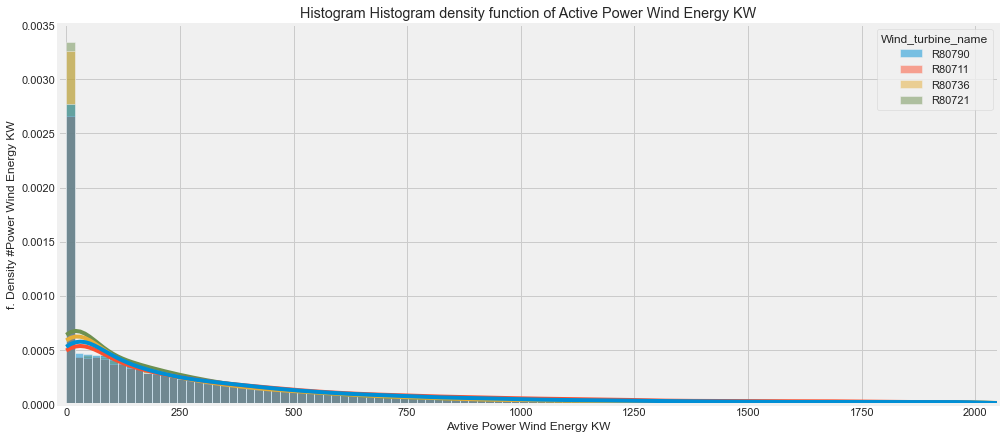

In [34]:
f.hisplot_active_power(df, 'P_avg', 'Wind_turbine_name')

La fréquence importance de valeurs à 0 en termes d'énergie produite indique que l'éolienne est à l'arrêt. 

Cela peut s'expliquer par plusieurs hypothèses, parmi lesquelles on distingue : 
- l'éolienne est en maintenance ou défectueuse
- il n'y a pas assez ou trop de vent pour qu'elle puisse tourner (14kh/h < vitesse > 90 km/h) 

La distribution anormale de notre target ne pose pas particulièrement problème. Il faudra envisager de la logarithmer au besoin. 

## Comprendre le comportement de la "windspeed"

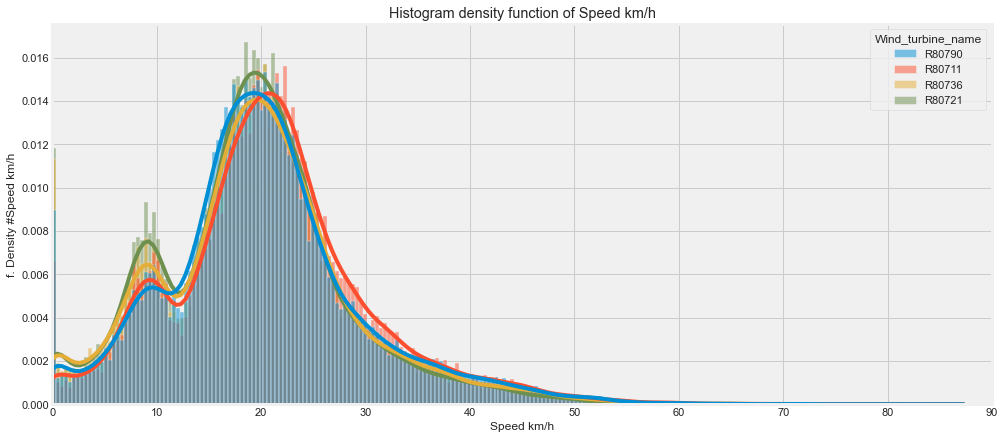

In [35]:
f.hisplot_windspeed(df, 'Speed km/h', 'Wind_turbine_name')

Notre distribution ressemble à une distribution polynomiale. Appliquer le modèle de polynomial features ?
Nous n'avons pas de différences notables en termes de distribution entre les éoliennes. Toutefois, certaines semblent détecter davantage de vent, de part peut-être leur position et leur système d'orientation (angle).

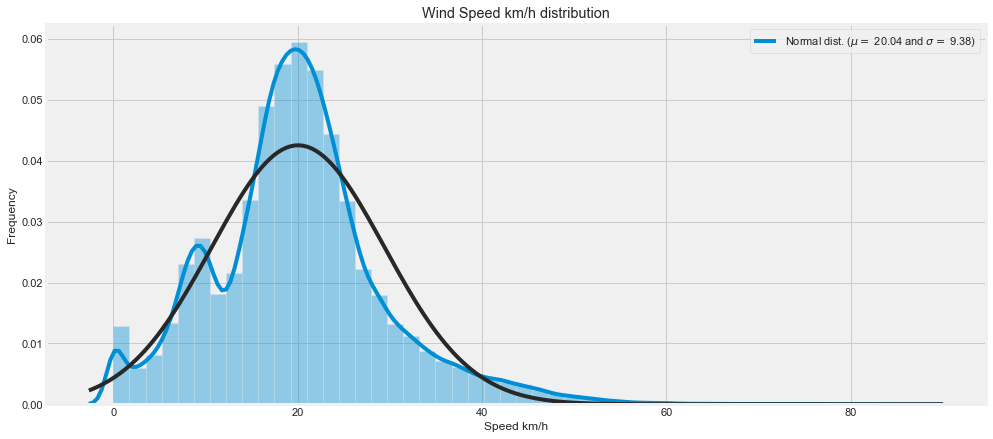

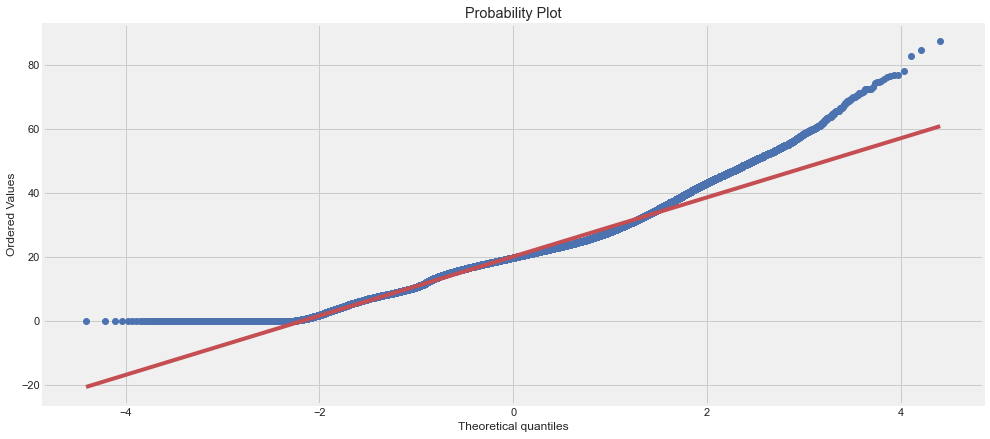

Skewness : 0.62
Kurtosis : 1.43


In [36]:
f.show_dist('Speed km/h', df, 'Wind Speed km/h distribution')

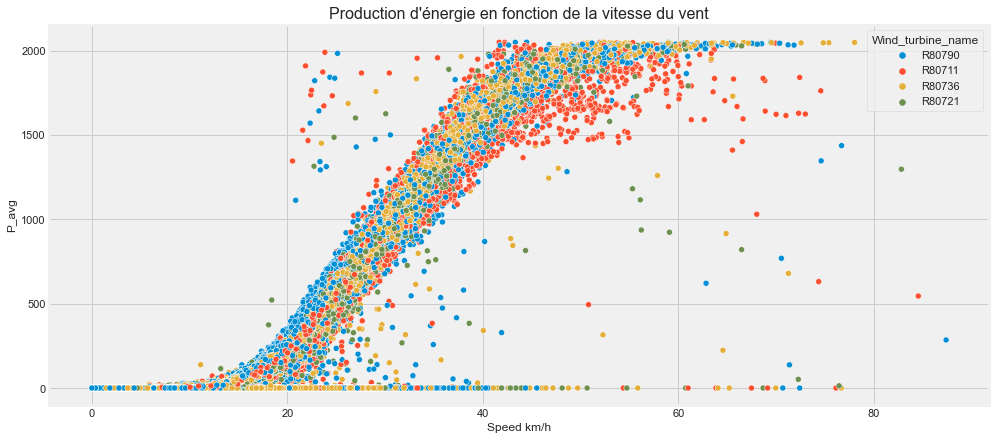

In [37]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df, x='Speed km/h', y='P_avg', hue='Wind_turbine_name')
plt.title('Production d\'énergie en fonction de la vitesse du vent', fontsize=16)
plt.show()

Nous sommes bien en présence
Comprendre pourquoi quand j'ai du vent supérieur à 10, soit la puissance est au max, soit elle est au plus bas. 
Piste : obsolescence du matériel => essayer de comprendre les petits points intermédiaires. Faire avec une datetime pour comprendre ce phénomène. Problème de batterie. 

Note perso : vu que nous voulons généraliser notre modèle, il conviendrait peut-être de "supprimer" les valeurs qui seraient considérées comme aberrantes si la piste de l'obsolescence était retenue.

In [38]:
# f.join_residplot(df, 'Speed km/h', 'P_avg')

In [39]:
# sns.regplot(data=df, x='Ws_avg', y='P_avg')

Nous avons tout de même une corrélation positive.

## Focus sur la torque

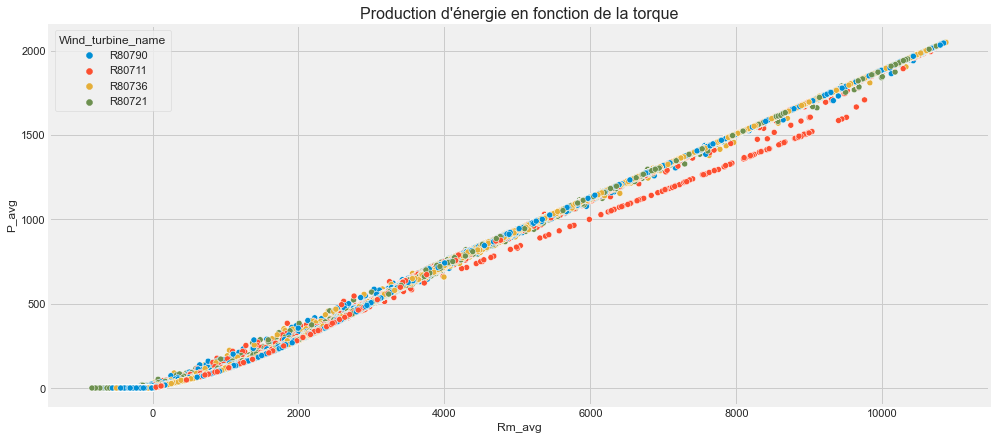

In [40]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df, x='Rm_avg', y='P_avg', hue='Wind_turbine_name')
plt.title('Production d\'énergie en fonction de la torque', fontsize=16)
plt.show()

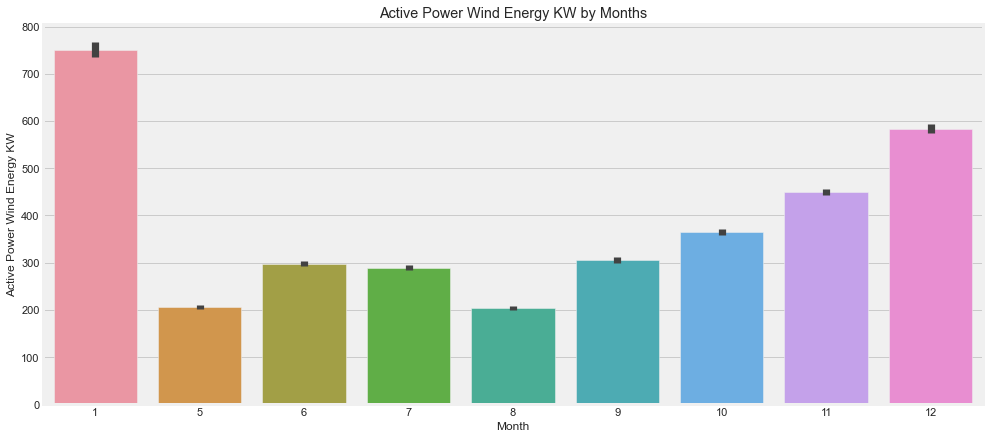

In [41]:
f.barplot_month('Month', 'P_avg', df)

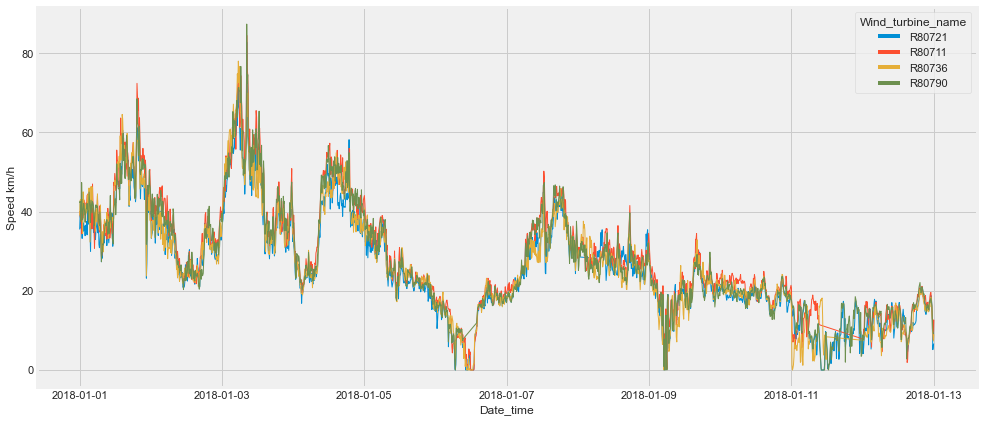

In [42]:
f.lineplot_month(df, 'Date_time', 'Speed km/h', 'Wind_turbine_name', 'Month == 1')

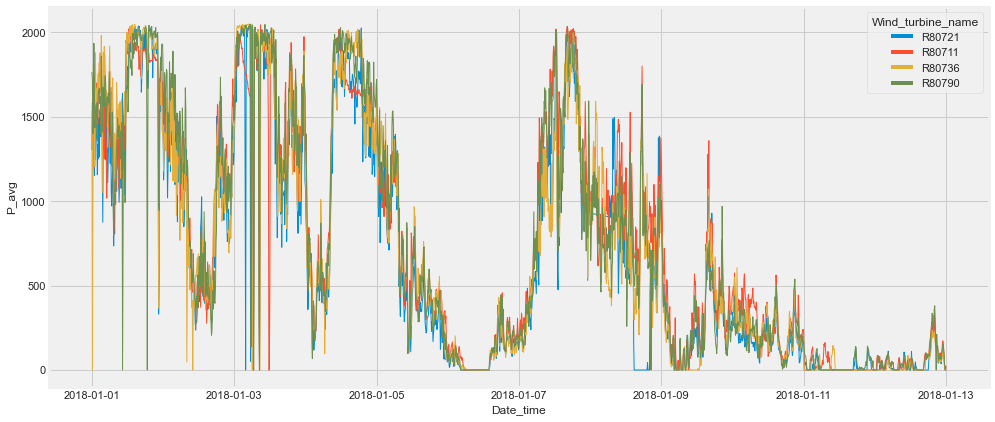

In [43]:
f.lineplot_month(df, 'Date_time', 'P_avg', 'Wind_turbine_name', 'Month == 1')

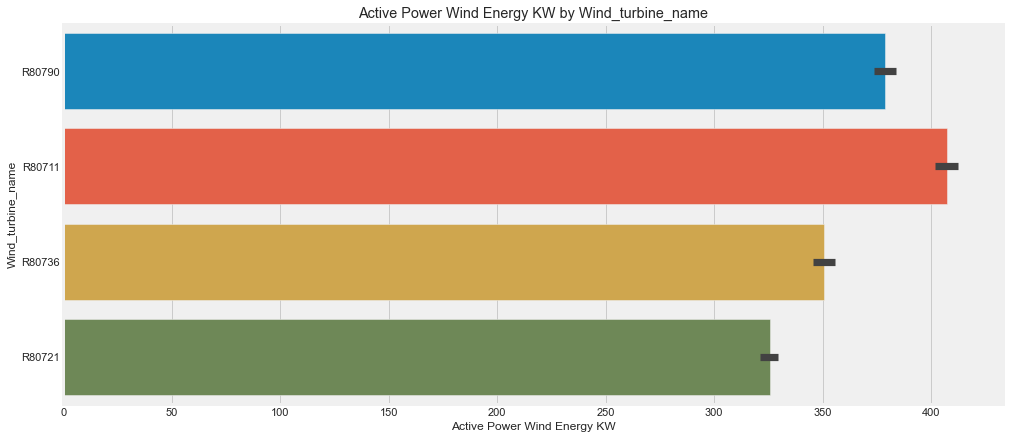

In [44]:
f.barplot_active_power('Wind_turbine_name', 'P_avg', df)